In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/deep_branching_with_domain"
except:
    pass

import os
import sys
import numbers
import math
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm 
import numpy as np
from scipy.stats import norm
from functools import partial
from IPython.display import Markdown as md
# add parent directory to system so that we can import the modules correctly
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from branch.galerkin import DGMNet
from branch.branch import Net

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The formula given by Borodin

In [2]:
def conditional_probability_to_survive(
    t,
    x,
    y,
    k_arr=range(-5, 5),
    lower_bound=-10,
    upper_bound=10,
):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose (t, x, y)
    # so that the operation with lower_bound, upper_bound is correct
    t = t.unsqueeze(dim=0).transpose(0, -1)
    x, y = x.transpose(0, -1), y.transpose(0, -1)

    # calculate the probability using the formula by Borodin
    ans = 0
    for k in k_arr:
        ans += (
            torch.exp(
                ((y - x) ** 2 - (y - x + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
            - torch.exp(
                ((y - x) ** 2 - (y + x - 2*lower_bound + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
        )
    # print(ans.transpose(0, -1).prod(dim=0))
    return ans.transpose(0, -1).prod(dim=0)

def is_x_inside(x, lower_bound=-10, upper_bound=10):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose x so that the operation with lower_bound, upper_bound is correct
    x = x.transpose(0, -1)

    return (
        torch.logical_and(lower_bound <= x, x <= upper_bound)
        .transpose(0, -1).all(dim=0)
    )

## Heat equation

The heat equation
$$
\begin{cases}
& \partial_t u_A(t, x) + \frac{\nu}{2}\Delta u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \Omega,
\\
& u_A(T, x) = 1_{x \in A}, \qquad \text{for all } x \in \Omega,
\\
& u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \partial\Omega,
\end{cases}
$$
where
$A = [a, b]$
and
$\Omega = [\text{lo}, \text{hi}]$,
admits the closed-form solution of
$$
u_A(t, x) = \sum\limits_{k=-\infty}^\infty \Phi\left(\frac{b - x + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right) - \Phi\left(\frac{a - x + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right) - \Phi\left(\frac{b + x - 2\text{lo} + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right) + \Phi\left(\frac{a + x - 2\text{lo} + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right).
$$
On the other hand, when $\text{hi} \to \infty$ and $\text{lo} \to -\infty$, the solution is given by
$$
u_A(t, x) = \Phi\left(\frac{b - x}{\sqrt{\nu(T-t)}}\right) - \Phi\left(\frac{a - x}{\sqrt{\nu(T-t)}}\right).
$$

In [3]:
problem_name = "heat_equation"
nu = 1
y, eps = 0, 1
a, b = y - eps, y + eps

# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return torch.zeros_like(y[0])

def phi_example(x, coordinate=0):
    return torch.logical_and(x[0] <= b, x[0] >= a).float()

def exact_example(t, x, T, coordinate=0, lower_bound=-10, upper_bound=10, with_bound=False, k_arr=range(-5, 5)):
    if t == T:
        return np.logical_and(x[0] <= b, x[0] >= a)
    else:
        normal_std = math.sqrt(nu * (T - t))
        if not with_bound:
            # without bound
            return norm.cdf((b - x[0]) / normal_std) - norm.cdf((a - x[0]) / normal_std)
        else:
            # with bound
            ans = 0
            for k in k_arr:
                mu = x[0] - 2 * k * (upper_bound - lower_bound)
                ans += (norm.cdf((b - mu) / normal_std) - norm.cdf((a - mu) / normal_std))
                mu = 2 * lower_bound - 2 * k * (upper_bound - lower_bound) - x[0]
                ans -= (norm.cdf((b - mu) / normal_std) - norm.cdf((a - mu) / normal_std))
            return ans

t_lo, x_lo, x_hi = 0., -2, 2

Patch 0: generation of u samples take 3.9784493446350098 seconds.
Patch  0: epoch    0 with loss 1.10E+01
Patch  0: epoch  500 with loss 1.87E-05
Patch  0: epoch 1000 with loss 1.77E-05
Patch  0: epoch 1500 with loss 1.69E-05
Patch  0: epoch 2000 with loss 1.63E-05
Patch  0: epoch 2500 with loss 1.58E-05
Patch  0: epoch 3000 with loss 5.41E-05
Patch  0: epoch 3500 with loss 4.72E-04
Patch  0: epoch 4000 with loss 1.66E-05
Patch  0: epoch 4500 with loss 3.49E-05
Patch  0: epoch 4999 with loss 1.72E-05
Patch 0: training of u with 5000 epochs take 45.48011088371277 seconds.
Patch 1: generation of u samples take 4.793854713439941 seconds.
Patch  1: epoch    0 with loss 2.11E+00
Patch  1: epoch  500 with loss 7.23E-06
Patch  1: epoch 1000 with loss 4.92E-06
Patch  1: epoch 1500 with loss 4.87E-06
Patch  1: epoch 2000 with loss 4.38E-06
Patch  1: epoch 2500 with loss 6.04E-06
Patch  1: epoch 3000 with loss 5.20E-06
Patch  1: epoch 3500 with loss 4.05E-06
Patch  1: epoch 4000 with loss 5.47E-

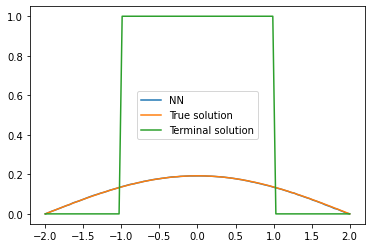

In [4]:
patches = 5
T = patches * 1.0

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(conditional_probability_to_survive, lower_bound=x_lo, upper_bound=x_hi),
    is_x_inside=partial(is_x_inside, lower_bound=x_lo, upper_bound=x_hi),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    overtrain_rate=0.,
)
model.train_and_eval(debug_mode=False)
model.compare_with_exact(exact_fun=partial(exact_example, lower_bound=x_lo, upper_bound=x_hi, with_bound=True))

In [5]:
md(f"[Link to log directory:](../{model.working_dir})")

[Link to log directory:](../logs/20220524-220526-heat_equation-T5.0-nu1)

## Kuramoto-Sivashinsky equation
$$
\partial_t u(t,x) + u \partial_x u(t, x) + \alpha \partial_{xx} u(t,x) + \beta \partial_{xxx} u(t, x) + \gamma \partial_{xxxx} u(t, x) = 0, \qquad (t,x) \in [0,T]\times \mathbb{R}.
$$

### Configuration 1
When $\alpha = \gamma = 1$ and $\beta = 4$,
the equation admits the traveling wave solution
$$
u(t,x) = 11 + 15 \tanh \theta - 15 \tanh^2 \theta - 15 \tanh^3 \theta,
$$
where
$\theta = -\frac{1}{2} x + t$.

In [27]:
problem_name = "kuramoto_equation_1"
alpha, beta, gamma = 1, 4, 1

# function definition
deriv_map = np.array([0, 1, 3, 4]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> third deriv
    idx 3 -> forth deriv
    """
    return (y[0] - 4) * y[1] + beta * y[2] + gamma * y[3]

def phi_example(x, coordinate=0):
    theta = -.5 * x[0]
    return (
        15
        + 15 * torch.tanh(theta)
        - 15 * (torch.tanh(theta))**2
        - 15 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T, coordinate=0, order=(0, 0)):
    theta = -.5 * x[0] - (T - t)
    if order[1] == 0:
        return (
            15
            + 15 * np.tanh(theta)
            - 15 * (np.tanh(theta))**2
            - 15 * (np.tanh(theta))**3
        )
    elif order[1] == 1:
        return -.5 / (np.cosh(theta))**2 * (
            15
            - 30 * np.tanh(theta)
            - 45 * (np.tanh(theta))**2
        )
    elif order[1] == 2:
        return (
            - .5 / (np.cosh(theta))**4 * (
                15 + 45 * np.tanh(theta)
            )
            - .5 * np.tanh(theta) / (np.cosh(theta))**2 * (
                15
                - 30 * np.tanh(theta)
                - 45 * (np.tanh(theta))**2
            )
        )
    elif order[1] == 3:
        return (
            11.25 / (np.cosh(theta))**6
            + .25 / (np.cosh(theta))**4 * (
                15 - 120 * np.tanh(theta) - 315 * (np.tanh(theta))**2
            )
            - .5 * (np.tanh(theta))**2 / (np.cosh(theta))**2 * (
                15
                - 30 * np.tanh(theta)
                - 45 * (np.tanh(theta))**2
            )
        )
    elif order[1] == 4:
        return (
            1 / (np.cosh(theta))**6 * (
                15 + 112.5 * np.tanh(theta)
            )
            + .5 * np.tanh(theta) / (np.cosh(theta))**4 * (
                30 - 165 * np.tanh(theta) - 405 * (np.tanh(theta))**2
            )
            - .5 * (np.tanh(theta))**3 / (np.cosh(theta))**2 * (
                15
                - 30 * np.tanh(theta)
                - 45 * (np.tanh(theta))**2
            )
        )

t_lo, x_lo, x_hi = 0., -10, 10

#### patches = 5, T = 0.5

Patch 0: generation of u samples take 81.90786957740784 seconds.
Patch  0: epoch    0 with loss 4.43E+01
Patch  0: epoch  500 with loss 1.95E-02
Patch  0: epoch 1000 with loss 1.82E-02
Patch  0: epoch 1500 with loss 1.87E-02
Patch  0: epoch 2000 with loss 2.10E-02
Patch  0: epoch 2500 with loss 1.81E-02
Patch  0: epoch 3000 with loss 1.86E-02
Patch  0: epoch 3500 with loss 1.81E-02
Patch  0: epoch 4000 with loss 1.81E-02
Patch  0: epoch 4500 with loss 1.81E-02
Patch  0: epoch 4999 with loss 1.80E-02
Patch 0: training of u with 5000 epochs take 46.00157713890076 seconds.
Patch 1: generation of u samples take 325.0890386104584 seconds.
Patch  1: epoch    0 with loss 4.16E+01
Patch  1: epoch  500 with loss 1.07E-01
Patch  1: epoch 1000 with loss 1.05E-01
Patch  1: epoch 1500 with loss 1.04E-01
Patch  1: epoch 2000 with loss 1.02E-01
Patch  1: epoch 2500 with loss 1.01E-01
Patch  1: epoch 3000 with loss 1.02E-01
Patch  1: epoch 3500 with loss 1.01E-01
Patch  1: epoch 4000 with loss 1.04E-0

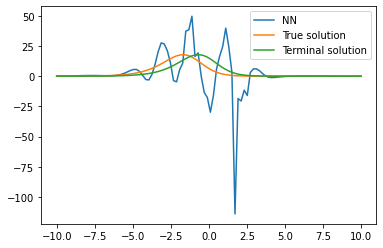

In [7]:
patches = 5
T = patches * .1

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(conditional_probability_to_survive, lower_bound=x_lo, upper_bound=x_hi),
    is_x_inside=partial(is_x_inside, lower_bound=x_lo, upper_bound=x_hi),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=2*alpha,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    outlier_multiplier=100,
    overtrain_rate=0.,
)
print(f"The model is saved to {model.working_dir}")
model.train_and_eval(debug_mode=False)
model.compare_with_exact(exact_example)

In [6]:
md(f"[Link to log directory:](../{model.working_dir})")

[Link to log directory:](../logs/20220524-222030-kuramoto_equation_1-T0.5-nu2)

#### patches = 2, T = .2

The model is saved to logs/20220525-091749-kuramoto_equation_1-T0.2-nu2


Patch 0: generation of u samples take 85.35497331619263 seconds.
Patch  0: epoch    0 with loss 5.04E+01
Patch  0: epoch  500 with loss 6.81E-02
Patch  0: epoch 1000 with loss 1.22E-02
Patch  0: epoch 1500 with loss 1.22E-02
Patch  0: epoch 2000 with loss 1.34E-02
Patch  0: epoch 2500 with loss 1.24E-02
Patch  0: epoch 3000 with loss 1.23E-02
Patch  0: epoch 3500 with loss 1.23E-02
Patch  0: epoch 4000 with loss 1.23E-02
Patch  0: epoch 4500 with loss 1.22E-02
Patch  0: epoch 4999 with loss 1.22E-02
Patch 0: training of u with 5000 epochs take 49.01965641975403 seconds.
Patch 1: generation of u samples take 314.9348282814026 seconds.
Patch  1: epoch    0 with loss 3.78E+01
Patch  1: epoch  500 with loss 1.28E-02
Patch  1: epoch 1000 with loss 1.19E-02
Patch  1: epoch 1500 with loss 1.12E-02
Patch  1: epoch 2000 with loss 2.73E-02
Patch  1: epoch 2500 with loss 1.10E-02
Patch  1: epoch 3000 with loss 1.04E-02
Patch  1: epoch 3500 with loss 9.95E-03
Patch  1: epoch 4000 with loss 1.00E-0

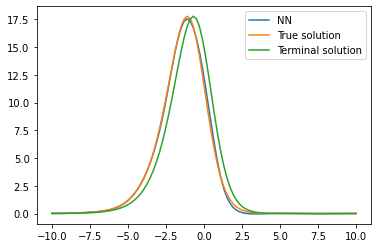

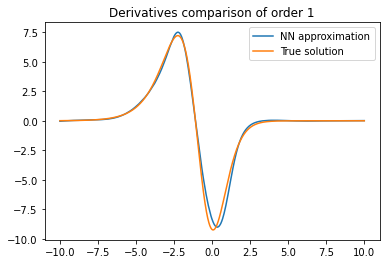

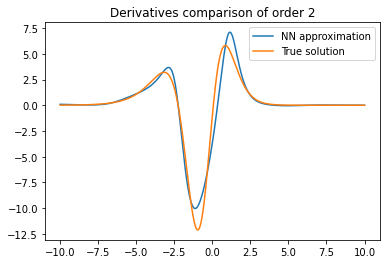

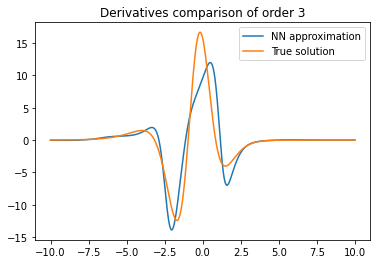

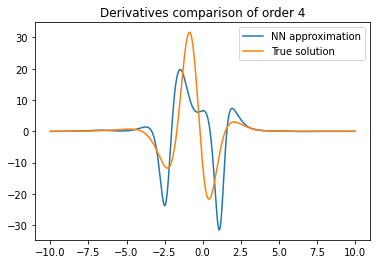

In [28]:
patches = 2
T = patches * .1

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(conditional_probability_to_survive, lower_bound=x_lo, upper_bound=x_hi),
    is_x_inside=partial(is_x_inside, lower_bound=x_lo, upper_bound=x_hi),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=2*alpha,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    outlier_multiplier=50,
    branch_activation="softplus",
    layers=6,
    neurons=50,
    branch_lr=1e-3,
    lr_gamma=.8,
    overtrain_rate=0.,
)
print(f"The model is saved to {model.working_dir}")
model.train_and_eval(debug_mode=False)
model.compare_with_exact(exact_example)

grid = np.linspace(x_lo, x_hi, 1000)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 1000)), grid_d_dim), axis=0)

# plot derivatives of all NN solutions for comparison
for order in ((0, 1), (0, 2), (0, 3), (0, 4)):
    true = exact_example(t_lo, grid_d_dim, T, order=order)
    x = torch.tensor(grid_d_dim_with_t.astype(np.float32), device=model.device, requires_grad=True)
    y =  model(x.T, patch=patches-1)
    deriv = model.nth_derivatives(order, y, x)
    plt.plot(grid, deriv.detach().cpu(), label="NN approximation")
    plt.plot(grid, true, label="True solution")
    plt.title(f"Derivatives comparison of order {order[1]}")
    plt.legend()
    plt.show()

In [7]:
md(f"[Link to log directory:](../{model.working_dir})")

[Link to log directory:](../logs/20220525-091749-kuramoto_equation_1-T0.2-nu2)

### Configuration 2
Next, we try $\alpha = \gamma = 1$ and $\beta = 0$,
with the terminal condition
$\phi(x) = e^{-x^2}$
and the boundary condition
$u(t, -10) = u(t, 10) = 0$.

In [10]:
problem_name = "kuramoto_equation_5"
alpha, gamma = 1, 1

# function definition
deriv_map = np.array([0, 1, 4]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> forth deriv
    """
    return y[0] * y[1] + gamma * y[2]

def phi_example(x, coordinate=0):
    return torch.exp(-x[0]**2)

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

Patch 0: generation of u samples take 106.74583506584167 seconds.
Patch  0: epoch    0 with loss 1.06E+01
Patch  0: epoch  500 with loss 7.76E-02
Patch  0: epoch 1000 with loss 5.29E-02
Patch  0: epoch 1500 with loss 3.23E-02
Patch  0: epoch 2000 with loss 3.11E-02
Patch  0: epoch 2500 with loss 3.09E-02
Patch  0: epoch 3000 with loss 3.08E-02
Patch  0: epoch 3500 with loss 3.11E-02
Patch  0: epoch 4000 with loss 3.08E-02
Patch  0: epoch 4500 with loss 3.07E-02
Patch  0: epoch 4999 with loss 3.07E-02
Patch 0: training of u with 5000 epochs take 49.75723719596863 seconds.
Patch 1: generation of u samples take 533.4041931629181 seconds.
Patch  1: epoch    0 with loss 4.22E+00
Patch  1: epoch  500 with loss 2.17E+00
Patch  1: epoch 1000 with loss 2.12E+00
Patch  1: epoch 1500 with loss 2.10E+00
Patch  1: epoch 2000 with loss 2.10E+00
Patch  1: epoch 2500 with loss 2.11E+00
Patch  1: epoch 3000 with loss 2.10E+00
Patch  1: epoch 3500 with loss 2.10E+00
Patch  1: epoch 4000 with loss 2.10E+

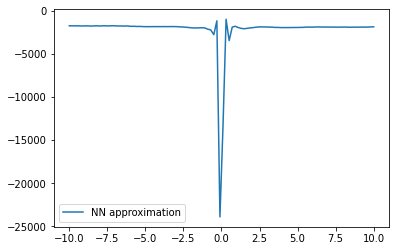

In [11]:
patches = 5
T = patches * .1

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(conditional_probability_to_survive, lower_bound=x_lo, upper_bound=x_hi),
    is_x_inside=partial(is_x_inside, lower_bound=x_lo, upper_bound=x_hi),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=2*alpha,
    branch_patches=patches,
    branch_nb_path_per_state=10000,
    overtrain_rate=0.,
)
print(f"The model is saved to {model.working_dir}")
model.train_and_eval(debug_mode=False)

# plot NN solution for comparison
nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device), patch=patches-1)
        .detach()
        .cpu()
        .numpy()
)
plt.plot(grid, nn, label="NN approximation")
plt.legend()
plt.show()

In [8]:
md(f"[Link to log directory:](../{model.working_dir})")

[Link to log directory:](../logs/20220524-230015-kuramoto_equation_5-T0.5-nu2)

## Navier-Stokes equation starting with the stationary flow
We consider the 2D Navier-Stokes equation inside the square $[0, 1]^2$. For this, we let the wall be the horizontal lines $y = 0$ and $y = 1$, and let the inlet at $x = 0$ flowing to the direction $x = 1$.

It can be checked that the velocity flow $u(t, x, y) = (y(1-y), 0)$ with the pressure $p(t, x, y) = \nu(1 -x)$ satisfies the Navier-Stokes equation
$$
\partial_t u(t,x) + \frac{\nu}{2} \Delta u(t,x) =\nabla p(t,x) + ( u \cdot \nabla ) u,
$$
with the divergence free condition ${\rm div \ \! } u = 0$.

In [5]:
# for plotting NS equation
def plot_wall(model, nb_spatial, x_lo, x_hi):
    lw, delta = 5, 1e-1
    plt.axis('scaled')
    plt.xlim(x_lo, x_hi)
    plt.ylim(x_lo, x_hi)

def plot_quiver_and_color(model, tt, x_lo, x_hi, x1, x2, u, nb_spatial, vmin=None, vmax=None, plt_velocity=True):
    # for velocity, the magnitute is the length
    # for pressure, the magnitute is simply itself
    magnitute = torch.sqrt(u[0]**2 + u[1]**2) if plt_velocity else u[0]
    subject = "velocity" if plt_velocity else "pressure"
    f = plt.figure()
    s = f.add_subplot(1, 1, 1, xlabel='$x$', ylabel='$y$')
    cmap=cm.coolwarm
    im = s.imshow(
        magnitute.reshape(nb_spatial, nb_spatial),
        cmap=cmap,
        extent=(x_lo, x_hi, x_lo, x_hi),
        origin='lower',
        vmin=vmin,
        vmax=vmax,
    )
    f.colorbar(im)
    plot_wall(model, nb_spatial, x_lo, x_hi)
    
    if plt_velocity:
        # use coarser grid
        x1 = x1.reshape(nb_spatial, nb_spatial)[::5, ::5].reshape(-1)
        x2 = x2.reshape(nb_spatial, nb_spatial)[::5, ::5].reshape(-1)
        u = u.reshape(2, nb_spatial, nb_spatial)[:, ::5, ::5].reshape(2, -1)
        plt.quiver(x1, x2, u[0], u[1], scale=10*(vmax - vmin))
        plt.title(f"{subject} flow at t = {tt}")
    plt.title(f"{subject} flow at t = {tt}")
    f.savefig(f"../{model.working_dir}/plot/t{tt}_{subject}.png", bbox_inches="tight", dpi=300)
    if isinstance(tt, numbers.Number) and (math.isclose(tt, model.t_lo) or math.isclose(tt, model.T)):
        plt.show()
    plt.close()

def plot_fluid(model, nb_time=21, nb_spatial=101, x_lo=None, x_hi=None):
    x_lo = model.x_lo if x_lo is None else x_lo
    x_hi = model.x_hi if x_hi is None else x_hi
    x1, x2 = np.meshgrid(
        np.linspace(x_lo, x_hi, nb_spatial + 2)[1:-1],
        np.linspace(x_lo, x_hi, nb_spatial + 2)[1:-1]
    )
    x1, x2 = x1.reshape(-1), x2.reshape(-1)
    time_arr = np.linspace(model.t_lo, model.T, nb_time)
    u = []
    for tt in time_arr:
        # create x
        x_tensor = torch.tensor(
            np.stack((tt * np.ones_like(x1), x1, x2)),
            device=model.device,
            dtype=torch.get_default_dtype()
        ).reshape(3, -1)
    
        # calculate u
        u.append(model(x_tensor.T, patch=0).T.detach().cpu())
    # merge all u together
    u = torch.stack(u, dim=0)
    
    # calculate terminal u & p
    terminal_u = torch.stack((
        model.phi_fun(x_tensor[1:], 0).cpu(),
        model.phi_fun(x_tensor[1:], 1).cpu(),
    ))
    p = model(x_tensor[1:].T, patch=0, p_or_u="p").T.detach().cpu()
    
    # plot
    magnitute = torch.sqrt(u[:, 0, :]**2 + u[:, 1, :]**2)
    magnitute = magnitute[~magnitute.isnan()]  # filter nan
    vmin, vmax = magnitute.min().item(), magnitute.max().item()
    for idx, tt in enumerate(time_arr):
        plot_quiver_and_color(model, tt, x_lo, x_hi, x1, x2, u[idx], nb_spatial, vmin, vmax)
    plot_quiver_and_color(model, "terminal", x_lo, x_hi, x1, x2, terminal_u, nb_spatial, vmin, vmax)
    plot_quiver_and_color(model, model.T, x_lo, x_hi, x1, x2, p, nb_spatial, plt_velocity=False)
    
    return x1, x2, u, p

In [9]:
problem_name = "navier_stokes_stationary"
nu = .02

t_lo, x_lo, x_hi = 0., 0, 1

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return -(x[1] - x_lo) * (x[1] - x_hi)
    else:
        return torch.zeros_like(x[0])

def p_example(x):
    return nu * (1 - x[0]).unsqueeze(dim=-1)

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/20220609-223946-navier_stokes_stationary-T5-nu0.02
Patch 0: generation of u samples take 451.43211007118225 seconds.
Patch  0: epoch    0 with loss 7.23E+00
Patch  0: epoch  500 with loss 2.97E-03
Patch  0: epoch 1000 with loss 3.63E-03
Patch  0: epoch 1500 with loss 9.87E-03
Patch  0: epoch 2000 with loss 8.43E-04
Patch  0: epoch 2500 with loss 4.17E-03
Patch  0: epoch 3000 with loss 4.76E-04
Patch  0: epoch 3500 with loss 5.22E-04
Patch  0: epoch 4000 with loss 1.02E-03
Patch  0: epoch 4500 with loss 8.88E-04
Patch  0: epoch 5000 with loss 1.60E-03
Patch  0: epoch 5500 with loss 4.75E-03
Patch  0: epoch 6000 with loss 3.04E-03
Patch  0: epoch 6500 with loss 1.99E-03
Patch  0: epoch 7000 with loss 1.06E-03
Patch  0: epoch 7500 with loss 8.97E-03
Patch  0: epoch 8000 with loss 5.94E-04
Patch  0: epoch 8500 with loss 3.55E-03
Patch  0: epoch 9000 with loss 1.67E-03
Patch  0: epoch 9500 with loss 3.60E-04
Patch  0: epoc

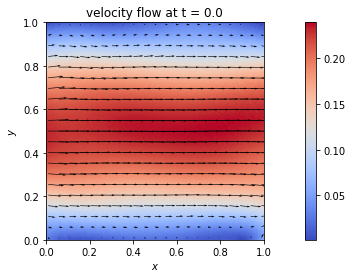

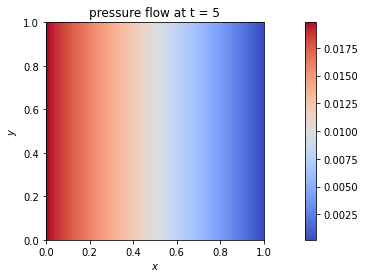

In [10]:
patches = 1
T = patches * 5
MAX_VAL = 100

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    exact_p_fun=p_example,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=10000,
    branch_nb_states_per_batch=1000,
    epochs=10000,
    fix_all_dim_except_first=False,
    fix_t_dim=True,
    overtrain_rate=0.,
    outlier_multiplier=10,
    save_as_tmp=False,  # change to False
)
model.train_and_eval(debug_mode=False)
x1, x2, u, p = plot_fluid(model, nb_time=1)

In [9]:
md(f"[Link to log directory:](../{model.working_dir})")

[Link to log directory:](../logs/20220609-223946-navier_stokes_stationary-T5-nu0.02)

## Time-dependent Poiseuille flow
We consider the 2D Navier-Stokes equation inside the square $[-L, L]^2$. For this, we let the wall be the horizontal lines $y = L$ and $y = L$, and let the inlet at $x = -L$ flowing to the direction $x = L$.

It can be checked that the velocity flow $u(t, x, y) = (g(t, y), 0)$ with the pressure $p(t, x, y) = -\nu x$ satisfies the Navier-Stokes equation
$$
\partial_t u(t,x) + \frac{\nu}{2} \Delta u(t,x) =\nabla p(t,x) + ( u \cdot \nabla ) u,
$$
with the divergence free condition ${\rm div \ \! } u = 0$,
where
$$
g(t, y) = L^2 - y^2 + \sum\limits_{n=0}^\infty \frac{32 (-1)^n L^2}{\pi^3(2n+1)^3} \cos \frac{(2n+1)\pi y}{2L} \exp\left(- \frac{(2n+1)^2 \pi^2 \nu (T-t)}{8L^2}\right).
$$

In [3]:
problem_name = "navier_stokes_poiseuille"
nu = .02

L = 1
t_lo, x_lo, x_hi = 0., -L, L

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        ans = L**2 - x[1]**2
        for n in range(10):
            ans += (
                32 * (-1)**n * L**2 / (math.pi * (2*n+1))**3
                * torch.cos((2*n+1) * math.pi * x[1] / (2 * L))
            )
        return ans
    else:
        return torch.zeros_like(x[0])

def p_example(x):
    return -nu * x[0].unsqueeze(dim=-1)

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/20220609-211105-navier_stokes_poiseuille-T100-nu0.02
Patch 0: generation of u samples take 3451.789483308792 seconds.
Patch  0: epoch    0 with loss 5.93E+00
Patch  0: epoch  500 with loss 5.21E-03
Patch  0: epoch 1000 with loss 5.02E-03
Patch  0: epoch 1500 with loss 4.94E-03
Patch  0: epoch 2000 with loss 5.55E-03
Patch  0: epoch 2500 with loss 4.84E-03
Patch  0: epoch 3000 with loss 5.15E-03
Patch  0: epoch 3500 with loss 4.85E-03
Patch  0: epoch 4000 with loss 5.26E-03
Patch  0: epoch 4500 with loss 4.94E-03
Patch  0: epoch 5000 with loss 5.22E-03
Patch  0: epoch 5500 with loss 4.85E-03
Patch  0: epoch 6000 with loss 4.87E-03
Patch  0: epoch 6500 with loss 4.88E-03
Patch  0: epoch 7000 with loss 5.06E-03
Patch  0: epoch 7500 with loss 5.57E-03
Patch  0: epoch 8000 with loss 5.04E-03
Patch  0: epoch 8500 with loss 4.91E-03
Patch  0: epoch 9000 with loss 4.87E-03
Patch  0: epoch 9500 with loss 4.84E-03
Patch  0: epo

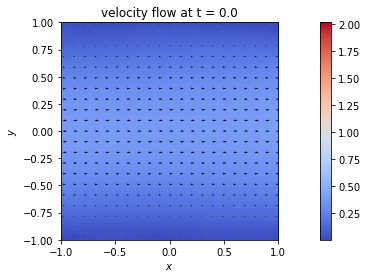

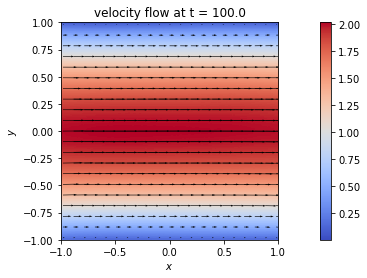

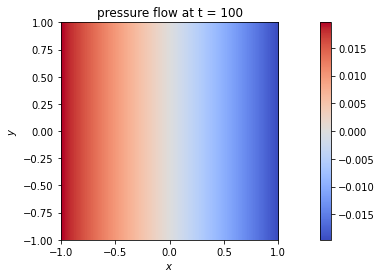

In [7]:
patches = 1
T = patches * 100
MAX_VAL = 100

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    exact_p_fun=p_example,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,  # change to 100000
    branch_nb_states_per_batch=1000,
    epochs=10000,  # change to 10000
    fix_all_dim_except_first=False,
    fix_t_dim=False,  # change to False
    overtrain_rate=0.,
    outlier_multiplier=10,
    save_as_tmp=False,  # change to False
)
model.train_and_eval(debug_mode=False)
x1, x2, u, p = plot_fluid(model, nb_time=21)  # change to 21

In [10]:
md(f"[Link to log directory:](../{model.working_dir})")

[Link to log directory:](../logs/20220609-211105-navier_stokes_poiseuille-T100-nu0.02)

In [32]:
# compare the x component of u at t = 0, x = 0, y = 0 with the closed-form solution
def sum_to_infinity(y, t):
    ans = 1 - y**2
    for n in range(10):
        ans += (
            32 * (-1)**n / (math.pi * (2*n+1))**3
            * np.cos((2*n+1) * math.pi * y / 2)
            * np.exp(-(2*n+1) * math.pi**2 * t / 8)
        )
    return ans

print(
    f"The closed-form solution should be {sum_to_infinity(0, nu*T)} "
    f"but the NN solution gives {u[0].reshape(2, 101, 101)[0, 50, 50].item()}."
)

The closed-form solution should be 1.0874996186653583 but the NN solution gives 0.38407430052757263.
